In [ ]:
"""
This Jupyter notebook implements the code from the
paper "Unveiling the Complex Morphologies of Sessile Droplets on Heterogeneous Surfaces"
for a substrate compared to the results of reference.
The notebook defines several global constants that describe the shape of the substrate.
These constants typically do not need to be modified.
A good entry point for the code is the function "radius".
This function calculates the radius matrix for a given droplet volume v.
The radius matrix is then processed by function " Height_volume",
which computes the droplet height H and the droplet surface area under specific m and n constraints.
By looping over a range of m and n values for a given droplet volume,
the surface area matrix is obtained through function "Main". The minimum value in the surface area matrix,
S_min, is identified, along with the corresponding parameters m and n.

Results:
The minimum surface area S_min and the corresponding parameters m and n
are identified, providing compariation the morphology of sessile droplets with reference 
"Morphological Transformation of Surface Femtodroplets upon Dissolution"
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import sys
import time
from scipy import optimize
from numpy import savetxt
import cv2
from scipy.optimize import fsolve 
from scipy.optimize import curve_fit

In [220]:
#From image in refrence to fit the base-contour-line function

# Load and resize the image
img = cv2.imread('image-flower2.png')
img_resized = cv2.resize(img, (1000, 1000))#need to rescale afterwards

# Convert to grayscale and apply binary thresholding
gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours and filter based on area
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
inner_contours = [cnt for cnt in contours if cv2.contourArea(cnt) < 800000]
# Draw inner contours
for cnt in inner_contours:
    cv2.drawContours(img_resized, [cnt], -1, (0, 255, 0), 5)

# Process the first inner contour if available
if inner_contours:
    cnt = inner_contours[0]
    points = cnt[:, 0, :]
    x = points[:, 0] - 500  # Centering
    y = points[:, 1] - 500

    # Convert to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    # Define a fitting function
    def fitting_func(theta, *params):
        ###Assuming guess function constructed by sine and cosine function
        return params[0] * sum(params[i] * np.sin((i // 2 + 1) * theta) if i % 2 == 0 else params[i] * np.cos((i // 2 + 1) * theta) for i in range(1, len(params)))+params[-1]
    initial_params = [1] * 50  # Adjust the number of parameters as needed 50=6*8+2
    params, _ = curve_fit(fitting_func, theta, r, p0=initial_params)

    # Print fitted parameters
    print("Fitted Polar Function Parameters:")
    # print(", ".join(f"{chr(97 + i)}: {params[i]:.2f}" for i in range(len(params))))
    print(", ".join(f"{[i]}: {params[i]:.4f}" for i in range(len(params))))
    print(params)
    # Generate fitted values
    theta_fit = np.linspace(min(theta), max(theta), 5000)
    r_fit = fitting_func(theta_fit, *params)

    # Convert fitted polar coordinates back to Cartesian
    x_fit = r_fit * np.cos(theta_fit) + 500
    y_fit = r_fit * np.sin(theta_fit) + 500

    # Draw the fitted function on the image
    for i in range(len(x_fit) - 1):
        cv2.line(img_resized, (int(x_fit[i]), int(y_fit[i])), (int(x_fit[i + 1]), int(y_fit[i + 1])), (255, 0, 0), 3)   

# Display the result
cv2.imshow('Contours', img_resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

Fitted Polar Function Parameters:
[0]: 0.0035, [1]: 2130.7249, [2]: -3.8013, [3]: -5047.1527, [4]: -205.9368, [5]: -271.8878, [6]: 5.7233, [7]: 2700.7049, [8]: -377.2662, [9]: -1051.5045, [10]: 8.6644, [11]: 20403.4195, [12]: -524.3956, [13]: 1387.7353, [14]: -51.6404, [15]: -3308.3626, [16]: 144.2540, [17]: -173.1144, [18]: 20.9514, [19]: 104.4514, [20]: -80.1983, [21]: 183.5405, [22]: -46.4588, [23]: -1204.7689, [24]: 253.4360, [25]: -238.0818, [26]: 49.7763, [27]: 123.2926, [28]: -120.1913, [29]: 182.6580, [30]: -80.6011, [31]: -858.7827, [32]: 404.6808, [33]: 120.4423, [34]: 95.3203, [35]: -1779.8005, [36]: -57.1163, [37]: -483.9698, [38]: -18.2319, [39]: 1017.4641, [40]: -34.5414, [41]: 83.8582, [42]: 66.9816, [43]: 506.3950, [44]: -243.6988, [45]: -56.0860, [46]: -72.5757, [47]: 806.7186, [48]: -24.7398, [49]: 377.6542
[ 3.46548733e-03  2.13072494e+03 -3.80131152e+00 -5.04715274e+03
 -2.05936785e+02 -2.71887834e+02  5.72325620e+00  2.70070486e+03
 -3.77266154e+02 -1.05150451e+03 

In [222]:
Dimensions=400
Dimensions_1 = 200
Dimensions_2= 200
PI = np.pi
P=0.5 # The parameter "p" in Equation S22
Q=4 # The parameter "q" in Equation S22
A=0.05 #Amplitude Parameter
global Dimensions, PI, R_0, DEGREE, P, Q, A

In [223]:
C_RANGES= np.reshape(np.linspace(1e-12, 0.999999, Dimensions), (-1,1))
#a1=np.linspace(1e-12,0.5-(0.999-0.5)/Dimensions_2, Dimensions_1) 
#a2=np.linspace(0.5,0.999, Dimensions_2) 
#C_RANGES= np.reshape(np.concatenate((a1, a2), axis=0), (-1,1))
THETA_RANGES = np.linspace(0, 2*PI, Dimensions)###Applying polar coordinates

In [245]:
def pertubation(theta):
    """
    Calculates the perturbation term Rb in Equation S22.

    Args:
        theta (array): The angle in the polar coordinate system..
        
    Returns:
        Rb (array): the perturbation term Rb in Equation S22.
    """
    return fitting_func(theta, *params)/500  #factor 500 is used to rescale so that 1 unit length =10.67 micrometers.
# print(pertubation(theta))

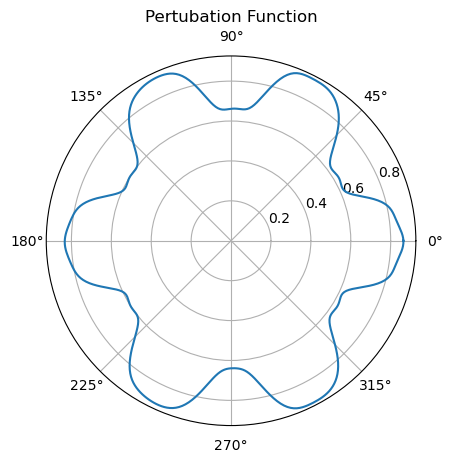

In [227]:
# Define theta values
theta_values = np.linspace(0, 2*PI, Dimensions)  # Adjust start, end, num_points as needed
results = [pertubation(theta) for theta in theta_values]###The radius array 

# Plotting
# plt.plot(theta_values, results)
# plt.title('Pertubation Function')
# plt.xlabel('Theta')
# plt.ylabel('Pertubation Value')
# plt.grid()
# plt.show()
# Plotting in polar coordinates
plt.polar(theta_values, results)
plt.title('Pertubation Function')
plt.show()

In [228]:
#1 unit =10.67 micrometers.
def dev_pertubation(theta, params):
    """
    Calculates the partial derivatives of perturbation term Rb with respect to angle theta

    Args:
        theta (array): The angle in the polar coordinate system..
        
    Returns:
        (array): the partial derivatives of perturbation term Rb with respect to angle theta

    """
    return 1.0/500*params[0] * sum(
        (params[i] * (i // 2 + 1) * np.cos((i // 2 + 1) * theta) if i % 2 == 0 
         else -params[i] * (i // 2 + 1) * np.sin((i // 2 + 1) * theta))
        for i in range(1, len(params))
    )

In [229]:
def radius(theta, c,m, P, Q):
    """
    This function generates a radius matrix.

    Args:
        theta (array-like): An array of angle ranges from 0 to 2π with a length of "dimension_theta".
        c (array-like): An array of the parameter "c" ranging from 0 to 1 with a length of "dimension_c".
        m (float): A scaling factor parameter "f(c)" as described in the referenced paper.
        P global variable The parameter "p" in Equation S22
        Q global varibale The parameter "q" in Equation S22

    Returns:
        numpy.ndarray: A radius matrix of size "dimension_theta" x "dimension_c" for the specified parameter "m".
    """
    pertu = pertubation(theta)
    scalling = 1/(np.power((1+c), m))
    r = scalling*np.power(1-c, P)*params[-1]/500+np.power(1-c, Q)*(pertu-params[-1]/500)###use R_0=0.561 to sure the surface = 1
    return r

In [230]:
def Dev_r_theta(theta, c, P, Q):
    """
    Calculates the partial derivatives of the radius with respect to the angle
    (\(\partial R / \partial \theta\)), as described in Equation S23.

    Args:
        theta (array-like): Array of angle ranges from 0 to \(2\pi\), 
        with a length specified by the "dimension_theta".
        c_ranges (array-like): Array of parameter "c" ranges from 0 to 1,
        with a length specified by the "dimension_c".
        P global variable The parameter "p" in Equation S22
        Q global varibale The parameter "q" in Equation S22
    Returns:
        numpy.ndarray: Matrix of partial derivatives of the radius with respect to the angle,
        i.e. in Equation S23.
    """
    dev_per = dev_pertubation(theta, params)
    d_r = np.power((1-c), Q)*dev_per
    return d_r

In [231]:
def Dev_r_c(theta, c, m, P, Q):
    """
    Calculates the partial derivatives of the radius with respect to the parameter (c)
    (\(\partial R / \partial c\)), as described in Equation S24.

    Args:
        theta (array-like): Array of angle ranges from 0 to \(2\pi\), 
        with a length specified by the "dimension_theta".
        c_ranges (array-like): Array of parameter "c" ranges from 0 to 1,
        with a length specified by the "dimension_c".
        m (float): Scaling factor parameter "f(c)" as described in the paper.
        P global variable The parameter "p" in Equation S22
        Q global varibale The parameter "q" in Equation S22
    Returns:
        numpy.ndarray: Matrix of partial derivatives of the radius with respect to the parameter (c),
        i.e. in Equation S24.
    """
    pertu = pertubation(theta)
    A = 1/(np.power((1+c), m))
    B = np.power(1-c, P)*params[-1]
    dA = -m*np.power(1+c, -m-1)
    dB = -P*np.power(1-c, P-1)*params[-1]/500
    dC = -(pertu-params[-1]/500)*Q*((1-c)**(Q-1))####require C != 1, when C == 1, there will be a signarity.
    d_r = A*dB+B*dA+dC
    return d_r

In [232]:
def Dev_h_c(c, n):
    """
    This function computes the partial derivative of height (h) with respect to c,
    denoted as (\partial h)/(\partial c), which corresponds to the third part in Eq.S9 but without info of "H".

    Args:
        c (array): Array of parameter values ranging from 0 to c_max
        with 'dimension' number of elements.
        n (float): Parameter used in the droplet height definition h = H * c^n in the paper,
        where H is the droplet height.

    Returns:
    (array):Array of partial derivatives of height with respect to parameter c,
    scaled by a constant factor of H.
    """
    global Dimensions, PI, R_0, DEGREE, P, Q, A
    d_h = n*np.power(c, n-1)####set c_max=1
    return d_h

In [233]:
def Height_volume(v, n, M, Radius, Theta_ranges, C_ranges):
    """
    Calculates the height and the surface area of a droplet given its volume 'v' and parameters 'n' and 'm'.

    Args:
        v (float): Droplet volume.
        m (float): Scaling factor parameter 'f(c)' as defined in the paper.
        n (float): Parameter defining the droplet height 'h = Hc^n' in the paper,
        where 'H' is the droplet height.
        Radius (ndarray): Matrix of radii corresponding to parameter 'm'.
        theta_ranges (ndarray): Array defining angle ranges from 0 to 2π with 'dimension_theta' length.
        C_ranges (ndarray): Array defining parameter 'c' ranges from 0 to 1 with 'dimension_c' length.

    Returns:
        H (float): Droplet height under parameters 'n' and 'm'.
        surface_size (float): Droplet surface area under parameters 'n' and 'm'.
    """
    dimen_c = len(C_ranges)
    
    d_theta = Theta_ranges[1]-Theta_ranges[0]#(Theta_ranges[-1]-Theta_ranges[0])/Dimensions
    C_RANGES_diff = np.diff(C_ranges, axis=0)
    C_RANGES_diff = np.reshape(np.append(C_RANGES_diff, C_RANGES_diff[-1,0] ), (-1,1))
    d_c = C_RANGES_diff
    d_base_area = 0.5*(Radius**2)*d_theta


    d_h = Dev_h_c(C_ranges, n)
    dv = (d_base_area*d_h)*d_c

    volume = np.sum(dv)

    H = v/volume
     
    d_r_theta = Dev_r_theta(Theta_ranges, C_ranges, P,Q)
    d_r_c = Dev_r_c(Theta_ranges, C_ranges, M,P,Q)
  
    d_h_c = H*d_h
    
    
    ds = np.sqrt(Radius**2+d_r_theta**2)*d_theta
    dl = np.sqrt(d_r_c**2+d_h_c**2)*d_c
    
    surface = ds*dl

    
    surface_size = np.sum(surface)
    
    return H, surface_size

In [234]:
def Main(v, n_ranges, m_ranges, Theta_ranges, C_ranges):
    """
    Calculates the minimum droplet surface area for a given volume.
    
    Args:
        v (float): Droplet volume.
        n_ranges (array-like): Array of possible values for parameter "n".
        m_ranges (array-like): Array of possible values for parameter "m".
        Theta_ranges (ndarray): Array defining angle ranges from 0 to 2π with 'dimension_theta' length.
        C_ranges (ndarray): Array defining parameter 'c' ranges from 0 to 1 with 'dimension_c' length.
       
    Returns:
        surface_min (float): Minimum surface area of the droplet.
        height_min (float): Corresponding height when the minimum surface area is achieved.
        surface_matrix (ndarray): Surface area matrix under dimensions specified by m_ranges*n_ranges.
        m_ranges[index[0]] (float): Parameter "m" value corresponding to the minimum surface area.
        n_ranges[index[1]] (float): Parameter "n" value corresponding to the minimum surface area.
    """
    n_length = len(n_ranges)
    m_length = len(m_ranges)
    surface_matrix = np.zeros((m_length, n_length))
    height_matrix = np.zeros((m_length, n_length))
    for i in range(m_length):
        Radius = radius(Theta_ranges, C_ranges, m_ranges[i],P,Q)
        for j in range(n_length):
            height, surface = Height_volume(v, n_ranges[j], m_ranges[i], Radius, Theta_ranges, C_ranges)
            surface_matrix[i][j] = surface
            height_matrix[i][j] = height
    surface_min = surface_matrix.min()
    index = np.where(surface_matrix==np.min(surface_matrix))
    height_min = height_matrix[index][0]
    return surface_min, height_min, surface_matrix, m_ranges[index[0]], n_ranges[index[1]]

In [235]:
m_ranges = np.arange(-1, 1, 0.01)
n_ranges = np.arange(0.6,2, 0.01)
Volume = [0.39]#,0.5,1]#[0.06,0.10,0.14, 0.18,0.5, 1, 1.5]
Surface = []
Height = []
Energy = []
m_matrix = []
n_matrix = []
for v in Volume:
    s,h,e,m,n = Main(v, n_ranges, m_ranges, THETA_RANGES, C_RANGES)
    Surface.append(s)
    Height.append(h)
    Energy.append(e)
    m_matrix.append(m)
    n_matrix.append(n)

In [236]:
Height

[0.4282231895001082]

In [237]:
Surface

[2.491618017460646]

In [238]:
m_matrix

[array([8.8817842e-16])]

In [239]:
n_matrix

[array([0.99])]

In [240]:
# surface_energy = Energy[0]
# Volume_sim = [0.06,0.10,0.14, 0.18,0.5, 1, 1.5]
# SS_sim = np.array([10395,11578,12986,14179,25421,41766,55506])*1e-4
# HH_sim = (np.array([20.61,27.72,34.06,39.19,71.78,102.28,122.06])-5)*0.01
# Radius = radius(THETA_RANGES, C_RANGES, m_matrix[0],P,Q)#####for droplet with volume = 0.18
# Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[0]*(C_RANGES)**n_matrix[0]######Change Here!
z_0 = np.ones(THETA_RANGES.shape[0])

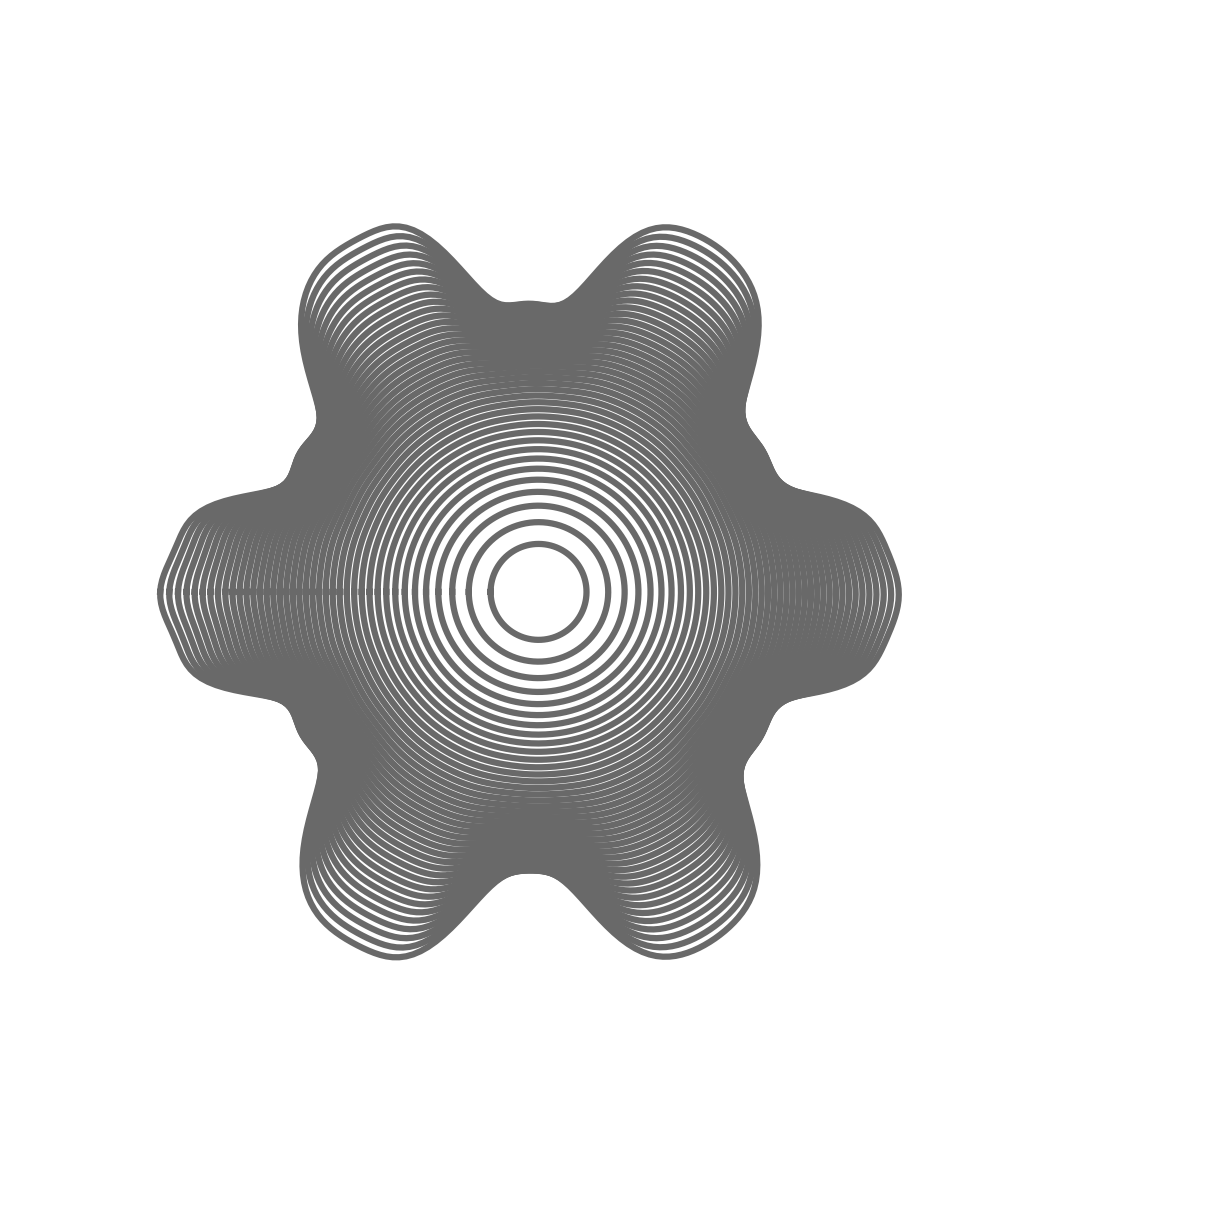

In [241]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
#ax.view_init(elev=-3, azim=0)
ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=90)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,10):
        ax.plot(x[i], y[i], z_0*z[i],color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
#ax.plot(x[5],y[5],z_0*z[5])
ax.set_zlim(0, 1.6)
ax.set_xlim(-1, 0.6)
ax.set_ylim(-0.8, 0.8)


ax.set_axis_off()
ax.grid(False)
#fig.savefig('contour_3Dhex01.pdf', bbox_inches='tight')

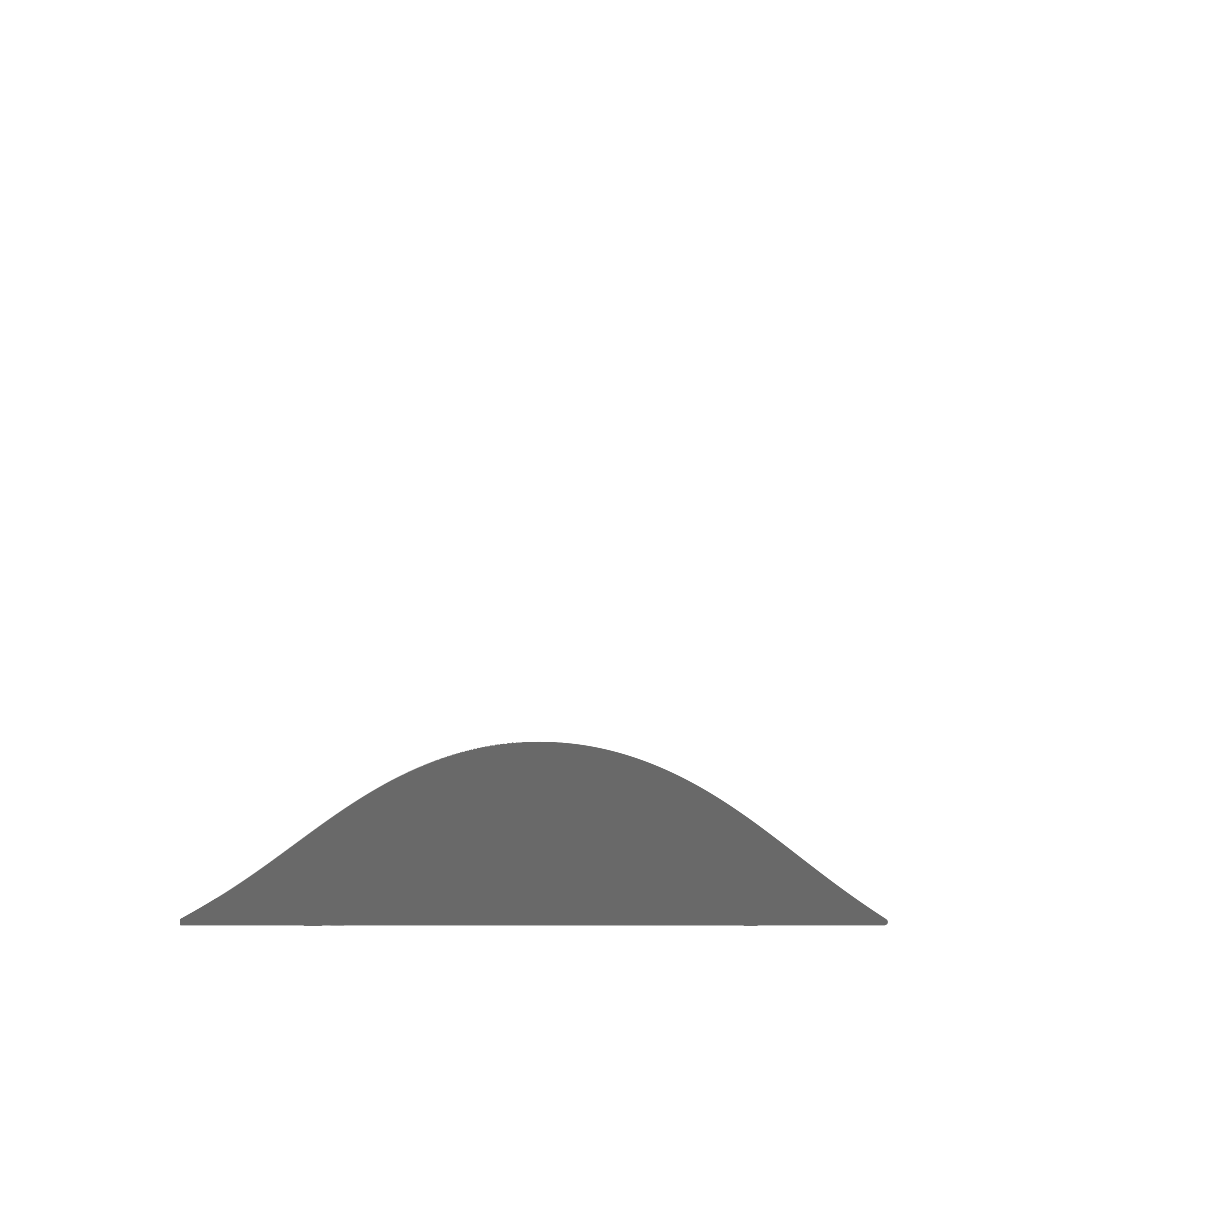

In [242]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
ax.view_init(elev=-3, azim=90)
# #ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=90)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i],color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
#ax.plot(x[5],y[5],z_0*z[5])
ax.set_zlim(0, 1.6)
ax.set_xlim(-1, 0.6)
ax.set_ylim(-0.8, 0.8)


ax.set_axis_off()
ax.grid(False)
fig.savefig('contour_3Dhex01.pdf', bbox_inches='tight')

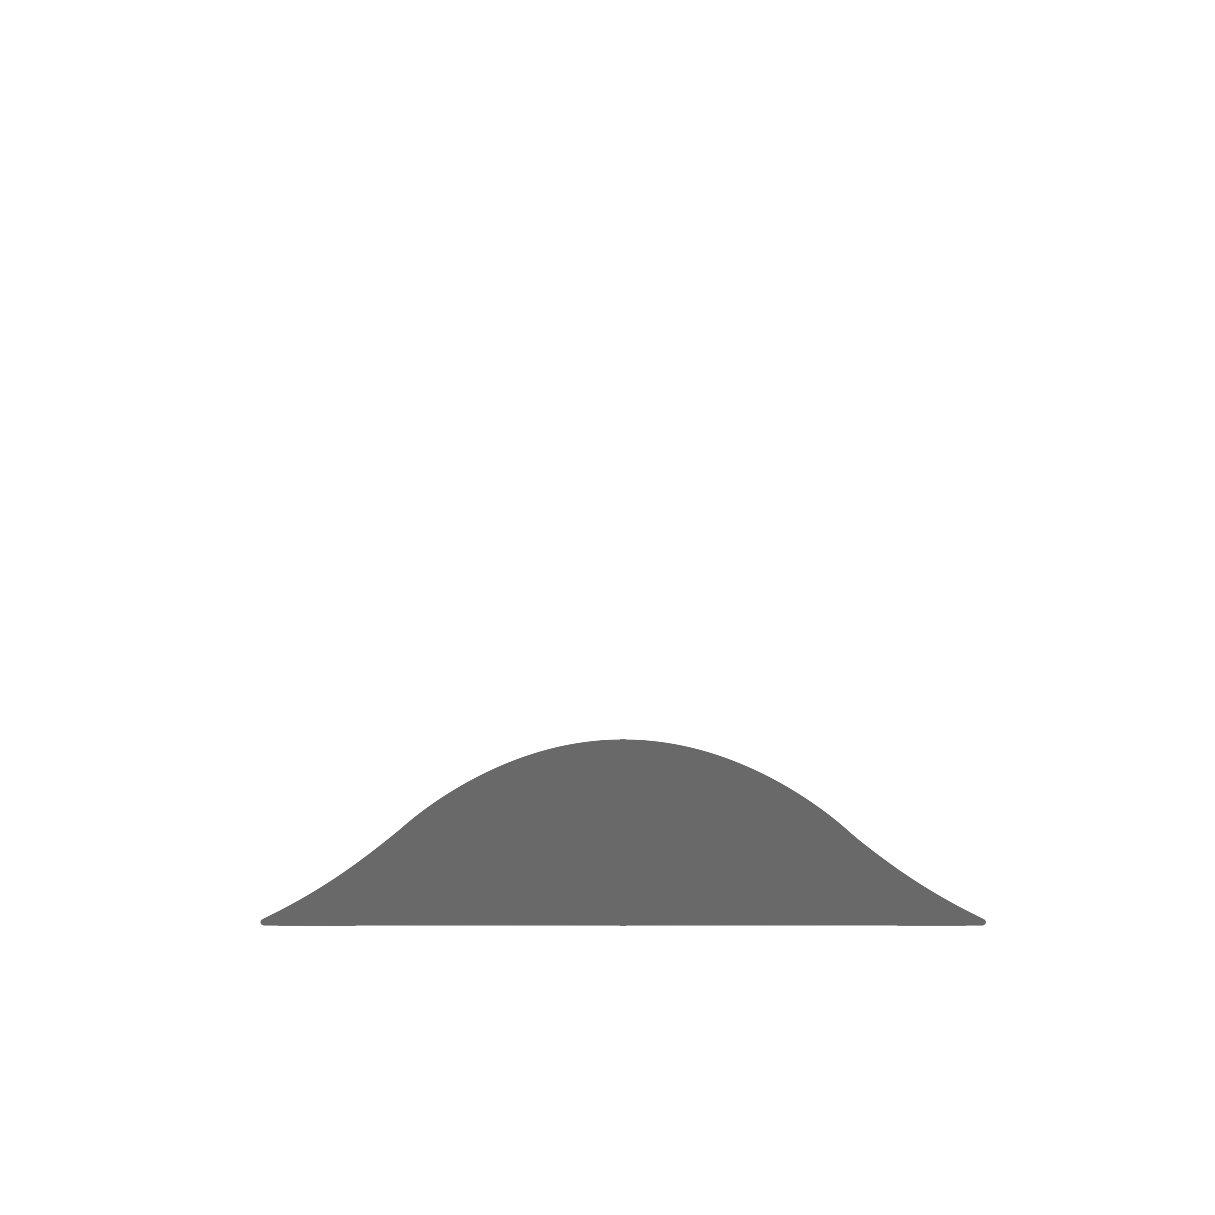

In [243]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
ax.view_init(elev=-3, azim=0)
# #ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=90)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i],color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
#ax.plot(x[5],y[5],z_0*z[5])
ax.set_zlim(0, 1.6)
ax.set_xlim(-1, 0.6)
ax.set_ylim(-0.8, 0.8)


ax.set_axis_off()
ax.grid(False)
fig.savefig('contour_3Dhex01.pdf', bbox_inches='tight')

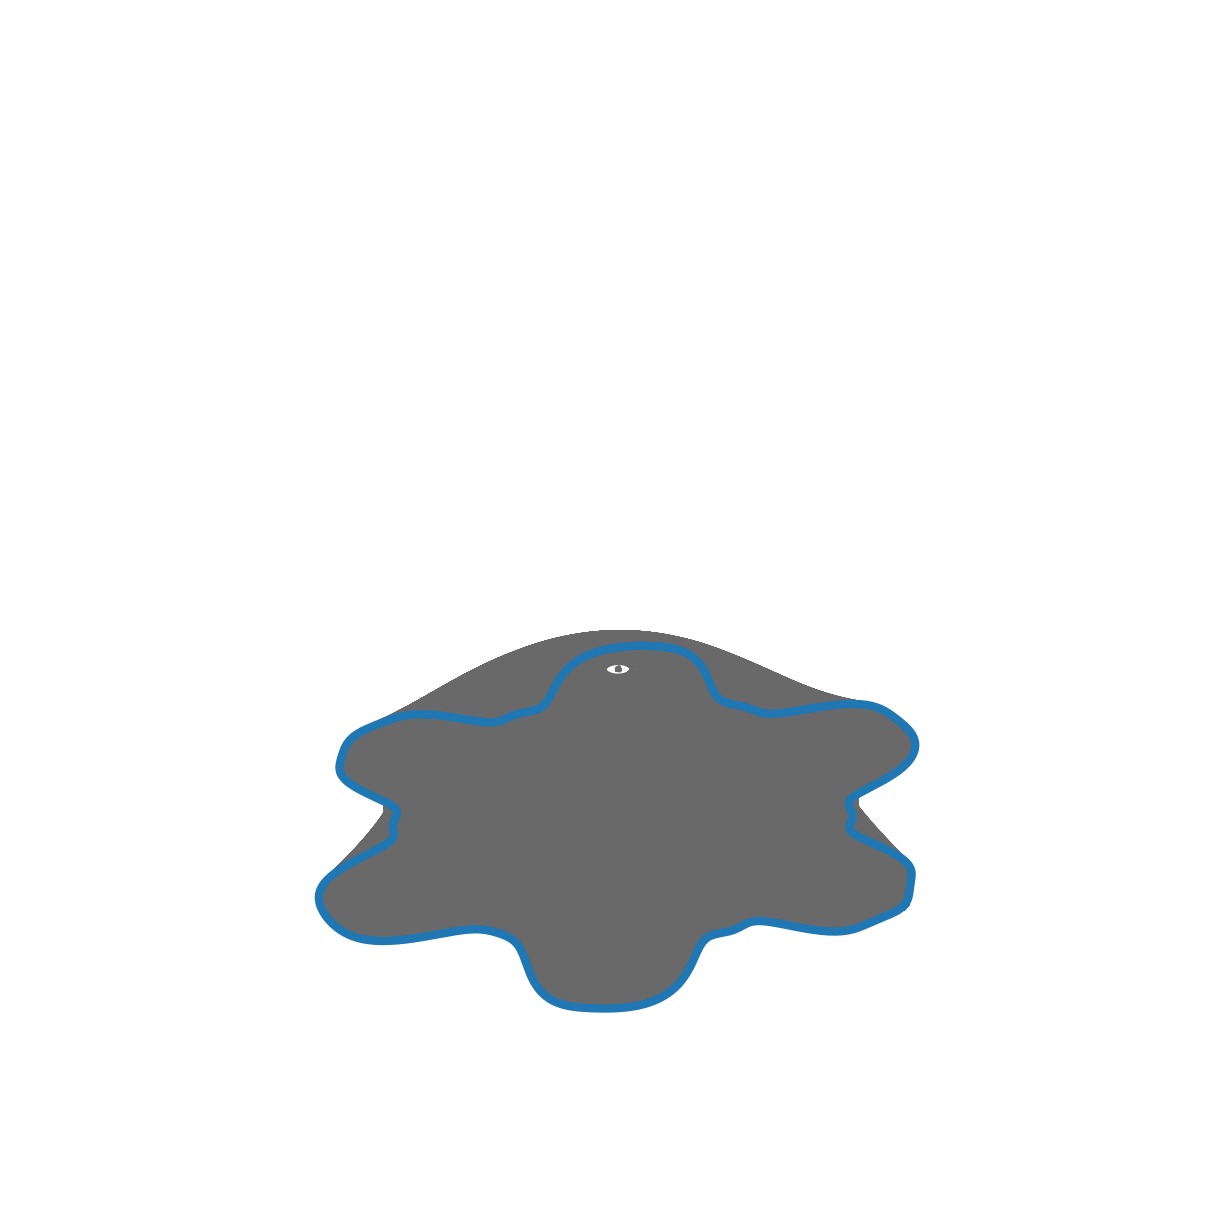

In [244]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,400,1):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-pertubation007_3D.pdf', bbox_inches='tight')

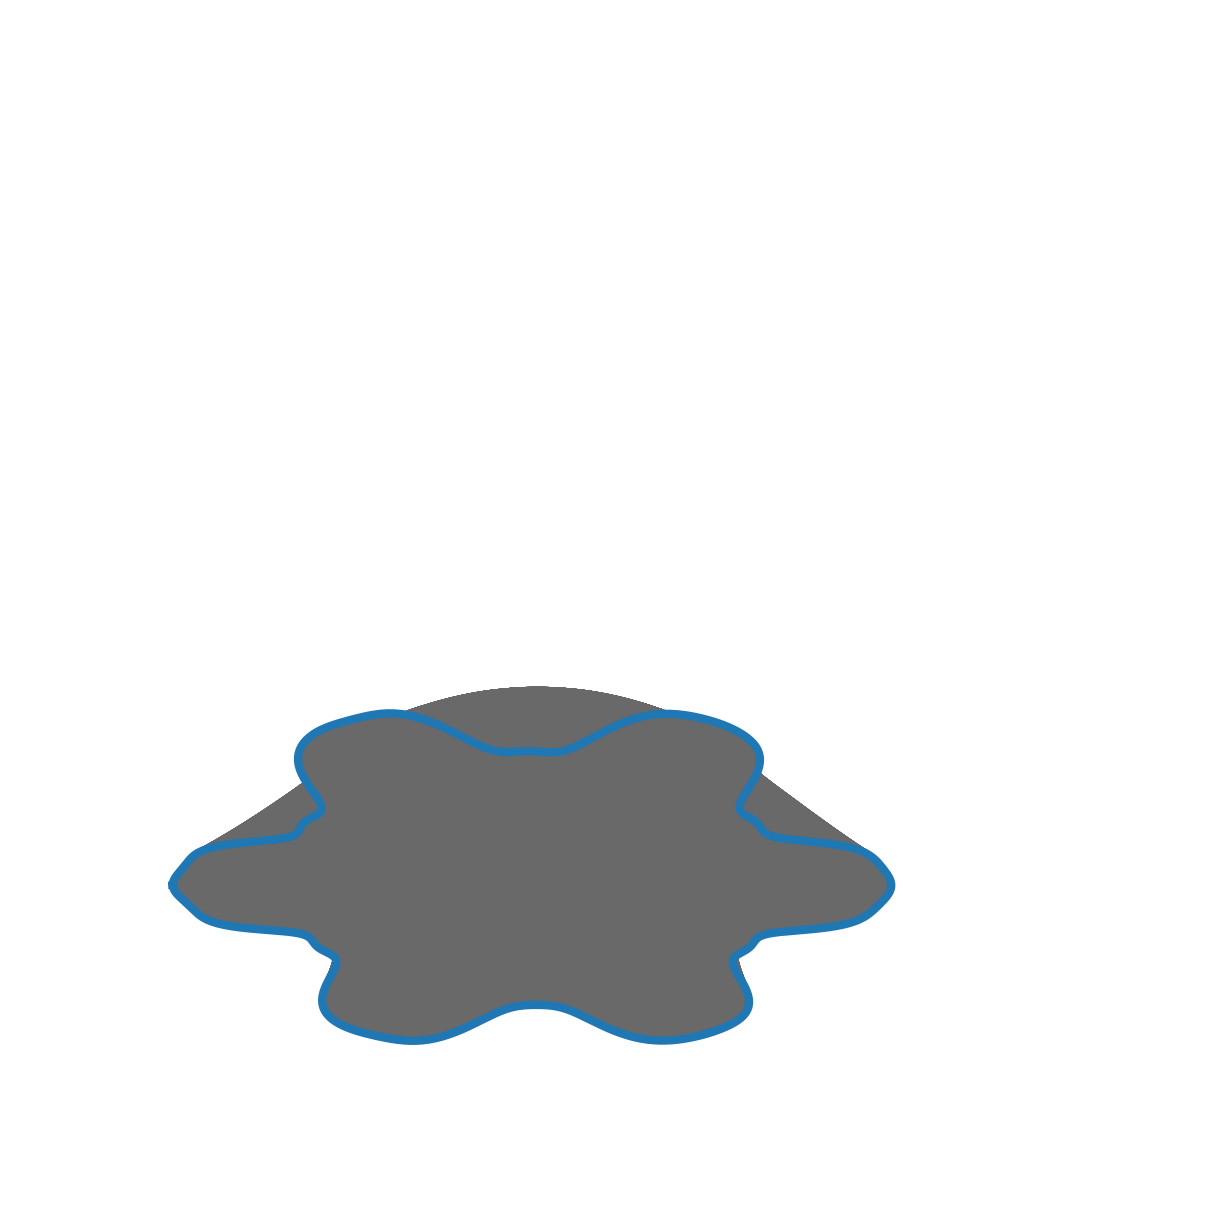

In [210]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
ax.view_init(elev=-30, azim=90)
# #ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=90)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i],color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
#ax.plot(x[5],y[5],z_0*z[5])
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0, 1.6)
ax.set_xlim(-1, 0.6)
ax.set_ylim(-0.8, 0.8)


ax.set_axis_off()
ax.grid(False)
fig.savefig('contour_3Dhex01.pdf', bbox_inches='tight')